In [1]:
import numpy as np
from struct import pack, unpack
import gzip
import torch
from torchvision import transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


np.random.seed(309)
torch.manual_seed(309)


def load_mnist_data(image_path, label_path):
    with gzip.open(image_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)

    with gzip.open(label_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return images, labels


def save_mnist_data(images, labels, output_image_path, output_label_path):
    '''save mnist data to gzip format'''
    num_images = images.shape[0]
    image_header = pack('>4I', 0x803, num_images, 28, 28)
    image_data = images.reshape(-1).tobytes()

    with gzip.open(output_image_path, 'wb') as f:
        f.write(image_header)
        f.write(image_data)

    label_header = pack('>2I', 0x801, num_images)
    label_data = labels.tobytes()

    with gzip.open(output_label_path, 'wb') as f:
        f.write(label_header)
        f.write(label_data)


def data_augmentation(image, label, augmentations=1):
    """data augmentation for mnist images"""
    augmented_samples = []
    original_image = torch.tensor(image.reshape(28, 28), dtype=torch.float32).unsqueeze(0)

    # transform pipeline
    transform = transforms.Compose([
        transforms.RandomRotation(degrees=(-15, 15)),  # random rotation
        transforms.RandomAffine(degrees=0, translate=(0.07, 0.07), fill=255),  # random affine
        transforms.RandomCrop(size=28, padding=2, fill=255),  # random crop
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 20),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 255)),
        transforms.Lambda(lambda x: x.squeeze(0).byte())
    ])

    for _ in range(augmentations):
        aug_image = transform(original_image)
        augmented_samples.append((aug_image.numpy().flatten(), label))

    return augmented_samples

In [2]:
original_image_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
original_label_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

train_imgs, train_labs = load_mnist_data(original_image_path, original_label_path)

# generate 10000 samples
selected_indices = np.random.choice(len(train_imgs), size=10000, replace=False)
augmented_data = []

for idx in tqdm(selected_indices, desc="Generating augmented data"):
    img = train_imgs[idx]
    label = train_labs[idx]
    augmented = data_augmentation(img, label, augmentations=1)
    augmented_data.extend(augmented)

aug_imgs = np.array([d[0] for d in augmented_data], dtype=np.uint8)
aug_labs = np.array([d[1] for d in augmented_data], dtype=np.uint8)

# stack original and augmented data
final_imgs = np.vstack([train_imgs, aug_imgs])
final_labs = np.hstack([train_labs, aug_labs])

Generating augmented data: 100%|██████████| 10000/10000 [00:09<00:00, 1045.90it/s]


In [3]:
assert final_imgs.shape == (70000, 784)
assert final_labs.shape == (70000,)

new_image_path = r'.\dataset\MNIST\train-images-idx3-ubyte-augmented.gz'
new_label_path = r'.\dataset\MNIST\train-labels-idx1-ubyte-augmented.gz'

save_mnist_data(final_imgs, final_labs, new_image_path, new_label_path)

print(f"the number of total samples: {len(final_imgs)}")
print(f"save path: {new_image_path}")
print(f"save path: {new_label_path}")

the number of total samples: 70000
save path: .\dataset\MNIST\train-images-idx3-ubyte-augmented.gz
save path: .\dataset\MNIST\train-labels-idx1-ubyte-augmented.gz


## Then we can explore the augmented data

In [1]:
import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt

path = r'.\dataset\MNIST\train-images-idx3-ubyte-augmented.gz'

with gzip.open(path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        aug_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)

print(magic)
print(num)
print(rows)
print(cols)
print(aug_imgs.shape)

2051
70000
28
28
(70000, 784)


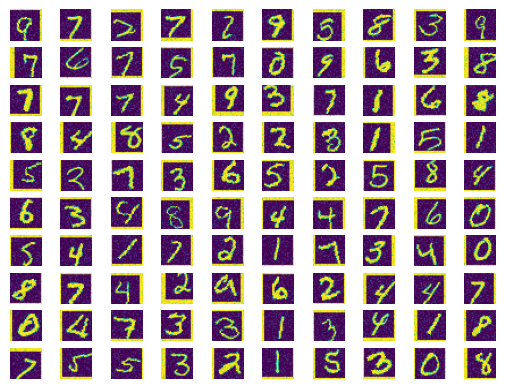

In [4]:
# The augmented data is saved in the last 10000 samples, so we can visualize them.
# Visualize the last 100 augmented images
for i in range(-101,-1):
    plt.subplot(10,10, i+102)
    plt.imshow(aug_imgs[i].reshape(rows, cols))
    plt.axis('off')

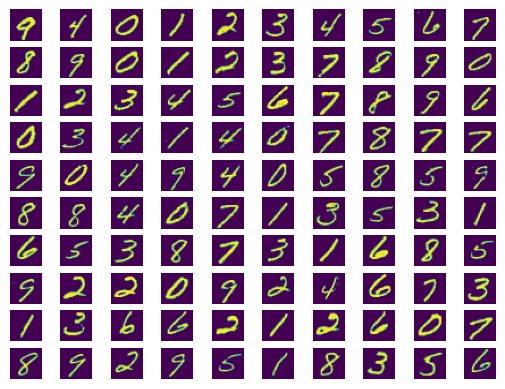

In [6]:
# we can also visualize the original data
path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'

with gzip.open(path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)

for i in range(-101,-1):
    plt.subplot(10,10, i+102)
    plt.imshow(imgs[i].reshape(rows, cols))
    plt.axis('off')